# Bitcoin - Regression

Examine bitcoin prices and see if we can predict the value.

### Importing required libraries

In [34]:
# importing required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [35]:
%%time
# Resampling data from minute interval to day
bit_df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
bit_df

Wall time: 1.75 s


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
1,1417412040,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
2,1417412100,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
3,1417412160,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
4,1417412220,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
...,...,...,...,...,...,...,...,...
1574269,1515369360,16174.21,16174.23,16174.21,16174.23,7.594119,122828.956770,16174.221301
1574270,1515369420,16174.23,16174.23,16174.21,16174.22,11.902468,192513.150940,16174.221081
1574271,1515369480,16174.22,16174.22,16174.21,16174.21,3.860840,62446.073684,16174.218136
1574272,1515369540,16174.22,16174.22,16174.21,16174.22,1.179093,19070.914509,16174.219514


In [36]:
%%time
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')

# Reset index
bit_df = bit_df.set_index('date')

# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'first', 'hi': 'max', 
    'lo': 'min', 'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

Wall time: 302 ms


In [37]:
bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
date,,,,,,,,
2015-04-15,221.05,224.52,218.09,224.35,9137.584626,2.029524e+06,222.270771,1.429056e+09
2015-04-16,224.35,230.75,223.66,229.45,8636.837666,1.970069e+06,227.779413,1.429142e+09
2015-04-17,229.45,230.08,220.46,223.62,7738.360003,1.741497e+06,224.970863,1.429229e+09
2015-04-18,223.55,224.04,222.18,224.02,5065.649127,1.131269e+06,223.398170,1.429315e+09
2015-04-19,224.02,226.72,223.44,224.03,5279.787312,1.185860e+06,224.667792,1.429402e+09
...,...,...,...,...,...,...,...,...
2018-01-03,14781.52,15400.00,14628.00,15098.14,17616.327677,2.642264e+08,14989.939350,1.514938e+09
2018-01-04,15098.23,15400.00,14230.00,15144.99,19567.016783,2.909045e+08,14851.477880,1.515024e+09
2018-01-05,15145.00,17178.00,14819.78,16960.01,22588.046307,3.619888e+08,15796.596968,1.515110e+09


## Predict tomorrow's close based on today's info?
We will use a row of data for input. We will call the input X and the prediction y. This is called "supervised learning" as we will feed in both X and y to train the model.

This performs better if we *standardize* the data.

Predict the open price from the ts component.

In [38]:
bit_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2015-04-15 to 2018-01-07
Freq: D
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     999 non-null    float64
 1   hi       999 non-null    float64
 2   lo       999 non-null    float64
 3   close    999 non-null    float64
 4   vol_btc  999 non-null    float64
 5   vol_cur  999 non-null    float64
 6   wp       999 non-null    float64
 7   ts       999 non-null    float64
dtypes: float64(8)
memory usage: 70.2 KB


### Visualizing the price vs time graph
Weighted price is the average price of an asset over a set period of time, weighted by volume. It is a useful indicator to eliminate noise in price movements for a given timespan.

<AxesSubplot:xlabel='Timespan', ylabel='Weighted Price'>

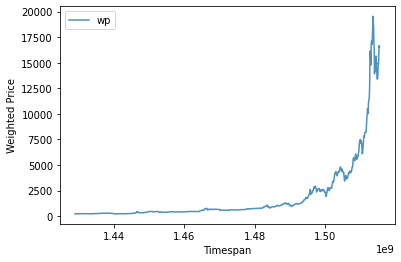

In [39]:
bit_df.plot(kind="line", x="ts", y="wp", alpha=0.8, xlabel="Timespan", ylabel="Weighted Price")

### Correlations

In [40]:
# to see the correlation of various features with the price
corr_matrix = bit_df.corr()
corr_matrix['open'].sort_values(ascending=False)

open       1.000000
wp         0.998800
hi         0.997562
close      0.997140
lo         0.996579
vol_cur    0.836192
ts         0.650204
vol_btc    0.526337
Name: open, dtype: float64

### Train-test split of the given dataset

In [41]:
# train-test split of dataset in 80:20 ratio
train_set, test_set  = train_test_split(bit_df, test_size=0.2, random_state=42)

# print the amount of data in each set
print(f"Rows in train set: {len(train_set)}\nRows in test set: {len(test_set)}\n")

Rows in train set: 799
Rows in test set: 200



In [42]:
# separate training and test dataset and target variable
bit_trainer = train_set.drop("close", axis=1)
bit_trainer_labels = train_set["close"].copy()

In [43]:
bit_trainer

,open,hi,lo,vol_btc,vol_cur,wp,ts
date,,,,,,,
2017-06-01,2303.61,2488.00,2302.00,21390.335043,5.133552e+07,2404.708652,1.496275e+09
2016-01-26,391.40,397.00,387.78,7307.824138,2.871685e+06,393.201605,1.453766e+09
2015-09-27,234.67,235.03,233.20,3969.849381,9.286271e+05,234.045693,1.443312e+09
2017-11-30,9920.81,10850.00,9135.60,39976.735392,3.973819e+08,10005.687826,1.512000e+09
2016-08-20,573.68,583.92,572.38,3689.790091,2.134917e+06,578.354288,1.471651e+09
...,...,...,...,...,...,...,...
2015-07-30,290.26,291.56,286.56,5502.373380,1.588231e+06,288.596448,1.438214e+09
2016-01-10,450.39,451.39,442.96,4151.636617,1.855103e+06,446.769576,1.452384e+09
2017-08-22,4002.00,4145.00,3583.46,21922.497310,8.557921e+07,3934.691782,1.503360e+09


In [44]:
bit_trainer_labels

date
2017-06-01    2419.99
2016-01-26     391.54
2015-09-27     233.58
2017-11-30    9903.00
2016-08-20     581.87
               ...   
2015-07-30     288.49
2016-01-10     449.99
2017-08-22    4092.00
2016-06-23     631.10
2015-07-26     293.89
Name: close, Length: 799, dtype: float64

### Using Standardization via pipeline.
((value - mean)/std)- Sklearn provides a class called StandardScaler for this.

In [45]:
bit_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

std_bit_trainer = bit_pipeline.fit_transform(bit_trainer)

In [46]:
std_bit_trainer.shape

(799, 7)

### Linear Regression and RandomForest Regression

In [47]:
# selecting a regression model (Linear regression and RandomForest Regression)
model = LinearRegression()
# model = RandomForestRegressor()

model.fit(std_bit_trainer, bit_trainer_labels)

LinearRegression()

### Evaluating the model on training data

In [48]:
# testing on small data - 5 sample rows
short_data = bit_trainer.iloc[:5]
short_labels = bit_trainer_labels.iloc[:5]

# passing the data through pipeline
piped_data = bit_pipeline.transform(short_data)

In [53]:
# predicting the prices for piped_data
model.predict(piped_data)

array([ 2429.83122604,   394.31060988,   238.4597271 , 10236.70245263,
         583.98256229])

In [54]:
# list actual prices for the 5 taken rows
list(short_labels)

[2419.99, 391.54, 233.58, 9903.0, 581.87]

### Model Score

In [56]:
# Checking the score of the model
model.score(piped_data, short_labels)

0.9983570597901493

### Predicting for the Test dataset

In [57]:
# predicting the price for the test dataset
X_test = test_set.drop("close", axis=1)
Y_test = test_set["close"].copy()

# passing the data through pipeline for standardization
X_test_piped = bit_pipeline.transform(X_test)
final_predictions = model.predict(X_test_piped)

In [59]:
# print final predictions and actual prices for the test dataset
print(final_predictions, list(Y_test))

[  657.59375797  2431.41566114   346.50475893   422.150468
  1255.15199685   698.86748731  3909.9011167    639.43812717
   670.13249489  1114.37157637  7517.57268023   903.52220957
  4303.10626694   771.3563875   1145.57330561   244.70909364
  2127.80421968   653.58023767   459.60409595   373.34120511
   707.69870071   469.48999047  4117.37809377  4015.48373053
  4419.34552164   235.42099939   240.22025294   446.17475485
  2538.03338109   416.71083163   742.83008841   435.32960547
   950.24353267   623.53986638   927.08820314  1186.51662001
   237.31903396   321.81340104  1021.17716548   773.67510526
  2945.23125821   456.82013929  7156.01666104   693.29966698
   314.19500924   720.27152932   433.07834367  1251.71017653
   260.63002387  4860.75677526   936.1456297    600.29643352
  8156.64728824   242.29328446   236.64812773   407.74141765
   233.1743855    615.35577478   618.18451479  1230.27025096
   228.77019115  1078.58081936  4652.34242213   628.69325506
  1041.48798243   441.7728

### Model Score on Test dataset

In [60]:
# checking the score for the test dataset
model.score(X_test_piped, Y_test)

0.9997265019294784

### Creating a new dataframe for Predictions and Actual prices

In [73]:
# creating a new dataframe for predictions on test dataset
new_df = pd.DataFrame()
new_df['time'] = X_test['ts']
new_df['predicted'] = final_predictions
new_df['actual'] = list(Y_test)

In [74]:
new_df

,time,predicted,actual
date,,,
2016-07-11,1.468195e+09,657.593758,650.97
2017-06-16,1.497571e+09,2431.415661,2480.43
2015-11-10,1.447114e+09,346.504759,337.14
2016-02-18,1.455754e+09,422.150468,421.19
2017-04-24,1.492992e+09,1255.151997,1257.29
...,...,...,...
2015-07-02,1.435795e+09,246.003259,254.85
2015-05-14,1.431562e+09,234.394518,237.46
2016-01-17,1.452989e+09,381.828730,378.46


In [75]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2016-07-11 to 2016-06-11
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       200 non-null    float64
 1   predicted  200 non-null    float64
 2   actual     200 non-null    float64
dtypes: float64(3)
memory usage: 6.2 KB
